In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import os
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sagemaker
from sagemaker.feature_store.feature_group import FeatureGroup, FeatureDefinition, FeatureTypeEnum
from sagemaker import get_execution_role
%matplotlib inline

In [10]:
# Read CSV
s3 = boto3.client('s3', "us-east-2")
# Read the file from the local filesystem
with open("day.csv", 'rb') as file_data:
    # Upload the file to S3
    s3.upload_fileobj(file_data, Bucket="sagemaker-domain-dev", Key="lauren-sso/day.csv")

In [8]:
read_file = s3.get_object(Bucket="sagemaker-domain-dev", Key="lauren-sso/day.csv")
bike = pd.read_csv(read_file['Body'],sep=',')

bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## DATA PREVIEW / SUMMARY

In [6]:
# Gives datatypes for ech column
bike.info()

# Gives important statistics for each column of the dataset
bike.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [7]:
# Gives rows, columns
print(bike.shape)

(730, 16)


## DATA QUALITY

In [8]:
# Count of Missing values by column
bike.isnull().sum().sort_values(ascending=False)

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [9]:
# Count of NULL values by column
bike.isnull().sum(axis=1).sort_values(ascending=False)

729    0
0      0
1      0
2      0
3      0
      ..
29     0
30     0
31     0
32     0
33     0
Length: 730, dtype: int64

In [10]:
# Count of duplicates

bike_dup = bike.copy()

# Checking for duplicates and dropping the entire duplicate row if any
bike_dup.drop_duplicates(subset=None, inplace=True)

# Checking for duplicates and dropping the entire duplicate row if any
bike_dup.drop_duplicates(subset=None, inplace=True)

if bike.equals(bike_dup):
    print("There are no duplicates")
else:
    print("There are duplicates")


There are no duplicates


In [11]:
bike['season']=bike['season'].astype('category')
bike['weathersit']=bike['weathersit'].astype('category')
bike['mnth']=bike['mnth'].astype('category')
bike['weekday']=bike['weekday'].astype('category')

bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   instant     730 non-null    int64   
 1   dteday      730 non-null    object  
 2   season      730 non-null    category
 3   yr          730 non-null    int64   
 4   mnth        730 non-null    category
 5   holiday     730 non-null    int64   
 6   weekday     730 non-null    category
 7   workingday  730 non-null    int64   
 8   weathersit  730 non-null    category
 9   temp        730 non-null    float64 
 10  atemp       730 non-null    float64 
 11  hum         730 non-null    float64 
 12  windspeed   730 non-null    float64 
 13  casual      730 non-null    int64   
 14  registered  730 non-null    int64   
 15  cnt         730 non-null    int64   
dtypes: category(4), float64(4), int64(7), object(1)
memory usage: 72.5+ KB


In [12]:
# In terms of "binning", creating dummy variables takes categorical variables and "intervals" them 

# Use get_dummies to convert categorical variables into dummy/indicator variables
bike_new_dummies = pd.get_dummies(bike, columns=['mnth', 'weekday', 'season', 'weathersit'], 
                                 prefix=['mnth', 'weekday', 'season', 'weathersit'])

# Convert the new dummy columns to integers
dummy_columns = bike_new_dummies.columns[bike_new_dummies.columns.str.startswith(('mnth_', 'weekday_', 'season_', 'weathersit_'))]
bike_new_dummies[dummy_columns] = bike_new_dummies[dummy_columns].astype('uint8')
bike_new_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 38 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   instant       730 non-null    int64  
 1   dteday        730 non-null    object 
 2   yr            730 non-null    int64  
 3   holiday       730 non-null    int64  
 4   workingday    730 non-null    int64  
 5   temp          730 non-null    float64
 6   atemp         730 non-null    float64
 7   hum           730 non-null    float64
 8   windspeed     730 non-null    float64
 9   casual        730 non-null    int64  
 10  registered    730 non-null    int64  
 11  cnt           730 non-null    int64  
 12  mnth_1        730 non-null    uint8  
 13  mnth_2        730 non-null    uint8  
 14  mnth_3        730 non-null    uint8  
 15  mnth_4        730 non-null    uint8  
 16  mnth_5        730 non-null    uint8  
 17  mnth_6        730 non-null    uint8  
 18  mnth_7        730 non-null    

In [13]:
# Changed rows,columns from 730, 16 to 730, 30
print(bike_new_dummies.shape)

(730, 38)


## FEATURE GROUPS

In [14]:
bike_new = bike[['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
                 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
                 'cnt', 'casual', 'registered']]

# Convert dteday to ISO-8601 format
bike_new['dteday'] = pd.to_datetime(bike_new['dteday'], format='%d-%m-%Y').dt.strftime('%Y-%m-%dT%H:%M:%SZ')

# Ensure 'dteday' is of string type
bike_new['dteday'] = bike_new['dteday'].astype(str)

# Initialize SageMaker session
session = sagemaker.Session()
region = session.boto_region_name

# Initialize Boto3 client for SageMaker Feature Store
featurestore_runtime = boto3.client('sagemaker-featurestore-runtime', region_name=region)
sagemaker_client = boto3.client('sagemaker', region_name=region)

# Define the feature group name
feature_group_name = 'bike-share-feature-group'

# Define the feature definitions using FeatureDefinition class
feature_definitions = [
    FeatureDefinition(feature_name='instant', feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name='dteday', feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name='season', feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name='yr', feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name='mnth', feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name='holiday', feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name='weekday', feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name='workingday', feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name='weathersit', feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name='temp', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='atemp', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='hum', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='windspeed', feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name='cnt', feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name='casual', feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name='registered', feature_type=FeatureTypeEnum.INTEGRAL)
]

# Create the feature group
feature_group = FeatureGroup(
    name=feature_group_name,
    sagemaker_session=session,
    feature_definitions=feature_definitions
)

# Define the feature group schema
record_identifier_name = "instant"
event_time_feature_name = "dteday"

# Check if the feature group already exists and delete it if it does
try:
    sagemaker_client.describe_feature_group(FeatureGroupName=feature_group_name)
    print(f"Feature group '{feature_group_name}' already exists. Deleting it...")
    sagemaker_client.delete_feature_group(FeatureGroupName=feature_group_name)
    
    # Wait for the feature group to be deleted by checking its status
    while True:
        try:
            sagemaker_client.describe_feature_group(FeatureGroupName=feature_group_name)
            time.sleep(5)  # Wait for 5 seconds before checking again
        except sagemaker_client.exceptions.ResourceNotFound:
            print(f"Feature group '{feature_group_name}' successfully deleted.")
            break

except sagemaker_client.exceptions.ResourceNotFound:
    print(f"Feature group '{feature_group_name}' does not exist. Proceeding to create it...")

# Create the feature group in SageMaker Feature Store
feature_group.create(
    s3_uri=f"s3://{session.default_bucket()}/{feature_group_name}",
    record_identifier_name=record_identifier_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=get_execution_role(),
    description="Bike sharing data feature group"
)

# Wait until the feature group is in ACTIVE state before ingesting data
while True:
    response = sagemaker_client.describe_feature_group(FeatureGroupName=feature_group_name)
    status = response['FeatureGroupStatus']
    
    print(f"Current status: {status}")  # Debugging statement
    
    if status == 'Created':
        print(f"Feature group '{feature_group_name}' is now in CREATED state and ready for use.")
        break
    else:
        print(f"Unexpected status: {status}. Please check the feature group configuration.")
    
    time.sleep(15)  # Wait for 15 seconds before checking again

# Ingest data into the feature group
feature_group.ingest(data_frame=bike_new, max_workers=3, wait=True)

print(f"Features registered into the feature group '{feature_group_name}' successfully.")

Feature group 'bike-share-feature-group' already exists. Deleting it...
Feature group 'bike-share-feature-group' successfully deleted.
Current status: Creating
Unexpected status: Creating. Please check the feature group configuration.
Current status: Created
Feature group 'bike-share-feature-group' is now in CREATED state and ready for use.
Features registered into the feature group 'bike-share-feature-group' successfully.


## TRAIN/TEST SPLIT + RESCALING THE FEATURES

In [15]:
from sklearn.model_selection import train_test_split

# We should specify 'random_state' so that the train and test data set always have the same rows, respectively

np.random.seed(0)
df_train, df_test = train_test_split(bike_new_dummies, train_size = 0.70, test_size = 0.30, random_state = 333)

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 510 entries, 483 to 366
Data columns (total 38 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   instant       510 non-null    int64  
 1   dteday        510 non-null    object 
 2   yr            510 non-null    int64  
 3   holiday       510 non-null    int64  
 4   workingday    510 non-null    int64  
 5   temp          510 non-null    float64
 6   atemp         510 non-null    float64
 7   hum           510 non-null    float64
 8   windspeed     510 non-null    float64
 9   casual        510 non-null    int64  
 10  registered    510 non-null    int64  
 11  cnt           510 non-null    int64  
 12  mnth_1        510 non-null    uint8  
 13  mnth_2        510 non-null    uint8  
 14  mnth_3        510 non-null    uint8  
 15  mnth_4        510 non-null    uint8  
 16  mnth_5        510 non-null    uint8  
 17  mnth_6        510 non-null    uint8  
 18  mnth_7        510 non-null    uin

In [17]:
df_train.shape

(510, 38)

In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219 entries, 22 to 313
Data columns (total 38 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   instant       219 non-null    int64  
 1   dteday        219 non-null    object 
 2   yr            219 non-null    int64  
 3   holiday       219 non-null    int64  
 4   workingday    219 non-null    int64  
 5   temp          219 non-null    float64
 6   atemp         219 non-null    float64
 7   hum           219 non-null    float64
 8   windspeed     219 non-null    float64
 9   casual        219 non-null    int64  
 10  registered    219 non-null    int64  
 11  cnt           219 non-null    int64  
 12  mnth_1        219 non-null    uint8  
 13  mnth_2        219 non-null    uint8  
 14  mnth_3        219 non-null    uint8  
 15  mnth_4        219 non-null    uint8  
 16  mnth_5        219 non-null    uint8  
 17  mnth_6        219 non-null    uint8  
 18  mnth_7        219 non-null    uint

In [19]:
df_test.shape

(219, 38)

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_train.head()

,instant,dteday,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,...,weekday_4,weekday_5,weekday_6,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3
483,484,29-04-2019,1,0,0,18.791653,22.50605,58.7083,7.832836,2229,...,0,0,0,0,1,0,0,1,0,0
650,651,13-10-2019,1,0,0,16.126653,19.56980,49.4583,9.791514,2252,...,0,0,1,0,0,0,1,1,0,0
212,213,01-08-2018,0,0,1,31.638347,35.16460,55.0833,10.500039,729,...,0,0,0,0,0,1,0,1,0,0
714,715,16-12-2019,1,0,0,14.862500,18.49690,83.8750,6.749714,538,...,0,0,0,0,0,0,1,0,1,0
8,9,09-01-2018,0,0,0,5.671653,5.80875,43.4167,24.250650,54,...,0,0,0,1,0,0,0,1,0,0


In [21]:
df_train.columns

Index(['instant', 'dteday', 'yr', 'holiday', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'casual', 'registered', 'cnt', 'mnth_1', 'mnth_2',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
       'mnth_10', 'mnth_11', 'mnth_12', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'season_1',
       'season_2', 'season_3', 'season_4', 'weathersit_1', 'weathersit_2',
       'weathersit_3'],
      dtype='object')

In [22]:
# Apply scaler() to all the numeric variables

num_vars = ['temp', 'atemp', 'hum', 'windspeed','cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [23]:
df_train.head()

,instant,dteday,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,...,weekday_4,weekday_5,weekday_6,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3
483,484,29-04-2019,1,0,0,0.497426,0.487055,0.609956,0.194850,2229,...,0,0,0,0,1,0,0,1,0,0
650,651,13-10-2019,1,0,0,0.416433,0.409971,0.513852,0.255118,2252,...,0,0,1,0,0,0,1,1,0,0
212,213,01-08-2018,0,0,1,0.887856,0.819376,0.572294,0.276919,729,...,0,0,0,0,0,1,0,1,0,0
714,715,16-12-2019,1,0,0,0.378013,0.381804,0.871429,0.161523,538,...,0,0,0,0,0,0,1,0,1,0
8,9,09-01-2018,0,0,0,0.098690,0.048706,0.451083,0.700017,54,...,0,0,0,1,0,0,0,1,0,0


In [24]:
df_train.columns

Index(['instant', 'dteday', 'yr', 'holiday', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'casual', 'registered', 'cnt', 'mnth_1', 'mnth_2',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
       'mnth_10', 'mnth_11', 'mnth_12', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'season_1',
       'season_2', 'season_3', 'season_4', 'weathersit_1', 'weathersit_2',
       'weathersit_3'],
      dtype='object')

## BUILDING MULTIPLE LINEAR MODEL

In [25]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Assuming bike_new_dummies is already created as per your notebook

# Drop the 'dteday' column as it is non-numeric
bike_new_dummies = bike_new_dummies.drop(columns=['dteday'])

# Split the data into train and test sets
np.random.seed(0)
df_train, df_test = train_test_split(bike_new_dummies, train_size=0.70, test_size=0.30, random_state=333)

# Apply MinMaxScaler to the numeric variables
scaler = MinMaxScaler()
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

# Add the 'cnt' column back into df_train
df_train['cnt'] = bike_new_dummies['cnt']

# Identify the target variable and features
target_column = 'cnt'
if target_column in df_train.columns:
    y_train = df_train[target_column]
    X_train = df_train.drop(columns=[target_column])

    # List of columns to drop if they exist in the DataFrame
    columns_to_drop = ['instant', 'yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed']

    # Drop columns that are present in the DataFrame
    X_train = X_train.drop(columns=[col for col in columns_to_drop if col in X_train.columns])

    # Running RFE with the output number of the variable equal to 15
    lm = LinearRegression()
    rfe = RFE(estimator=lm, n_features_to_select=15)
    rfe = rfe.fit(X_train, y_train)

    print("RFE fitting is complete.")
else:
    print(f"Column '{target_column}' not found in the DataFrame.")


RFE fitting is complete.


In [51]:

#fit the trained model
lm.fit(X_train,y_train)


LinearRegression()

In [52]:
#Accuracy of the model
lr=lm.score(X_train,y_train)
print('Accuracy of the model :',lr)
print('Model coefficients :',lm.coef_)
print('Model intercept value :',lm.intercept_)

Accuracy of the model : 1.0
Model coefficients : [ 1.00000000e+00  1.00000000e+00  9.16616869e-14  6.57987239e-14
  5.83197929e-14  1.84369651e-13  1.40793755e-14  2.26237410e-14
 -2.25979856e-14 -9.81448507e-15 -4.52830643e-14 -3.53208137e-13
 -1.70567360e-14  1.11075729e-14  8.39019656e-14  3.15706724e-14
  5.13610125e-15  2.40612453e-14  3.16014739e-14  3.74174869e-14
 -2.13689081e-13 -5.84138838e-14 -1.44699135e-14  2.14948657e-14
  5.13889655e-14 -2.76755569e-14  1.63876976e-14  1.12878119e-14]
Model intercept value : -2.7284841053187847e-12


In [55]:
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split

#Cross validation prediction
predict=cross_val_predict(lm,X_train,y_train,cv=3)
predict

array([6304., 7109., 4266., 3786.,  822., 7639., 6778., 3389., 1530.,
       5204., 4727., 2832., 6421., 4302., 5046., 1927., 2028., 3163.,
       4035., 4570., 4067., 7359., 3777., 7393., 2732., 4484., 6359.,
       7175., 1891., 1526., 1248., 3068., 4714., 3368., 3429., 5409.,
       4785., 4845., 1446., 3727., 4765., 1685., 3053., 1913., 1683.,
       4773., 5409., 1996., 3544., 3542., 5566., 4665., 1360., 5668.,
       6883., 5805., 2843., 2659., 5923., 3510., 2895., 6861., 2056.,
       2689., 6852., 5202., 2729., 2034.,  623., 4362., 7058., 6734.,
       4127., 5259., 5511., 4046., 6536., 6203., 4669., 3956., 3331.,
       3351., 2227., 4590., 7335., 7580., 1865., 1162., 4792.,  754.,
        959., 1162., 4553., 1450., 1708., 3005., 2660., 4338., 4492.,
       3423., 4511., 1107., 3867., 6227., 5008., 5041., 5558., 5582.,
       5686., 6140., 7965., 4585., 4881., 4844., 1421., 7767., 1501.,
       1796., 7442., 1263., 5146., 4507., 2485., 1746., 7282., 6606.,
       3068., 8090.,

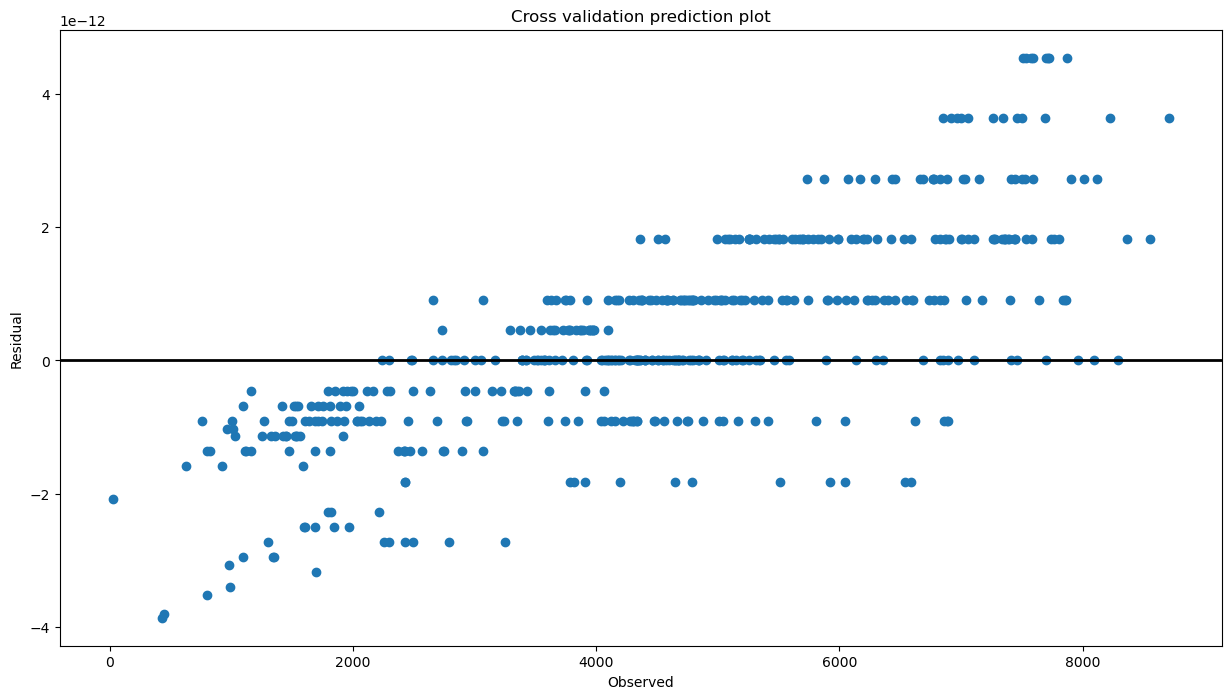

In [56]:
#Cross validation plot
fig,ax=plt.subplots(figsize=(15,8))
ax.scatter(y_train,y_train-predict)
ax.axhline(lw=2,color='black')
ax.set_title('Cross validation prediction plot')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [26]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('casual', True, 1),
 ('registered', True, 1),
 ('mnth_1', True, 1),
 ('mnth_2', True, 1),
 ('mnth_3', True, 1),
 ('mnth_4', True, 1),
 ('mnth_5', False, 3),
 ('mnth_6', True, 1),
 ('mnth_7', False, 9),
 ('mnth_8', False, 13),
 ('mnth_9', True, 1),
 ('mnth_10', True, 1),
 ('mnth_11', False, 12),
 ('mnth_12', True, 1),
 ('weekday_0', True, 1),
 ('weekday_1', False, 5),
 ('weekday_2', False, 14),
 ('weekday_3', False, 7),
 ('weekday_4', False, 6),
 ('weekday_5', False, 4),
 ('weekday_6', True, 1),
 ('season_1', True, 1),
 ('season_2', False, 8),
 ('season_3', False, 2),
 ('season_4', True, 1),
 ('weathersit_1', True, 1),
 ('weathersit_2', False, 10),
 ('weathersit_3', False, 11)]

In [27]:
# RFE is a method that recursively removes the least important features from the dataset to build a model with the most significant features. 
# It helps in improving the model’s performance by reducing overfitting and enhancing generalization

col = X_train.columns[rfe.support_]
col

Index(['casual', 'registered', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_6', 'mnth_9', 'mnth_10', 'mnth_12', 'weekday_0', 'weekday_6',
       'season_1', 'season_4', 'weathersit_1'],
      dtype='object')

In [28]:
X_train.columns[~rfe.support_]

Index(['mnth_5', 'mnth_7', 'mnth_8', 'mnth_11', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'season_2', 'season_3',
       'weathersit_2', 'weathersit_3'],
      dtype='object')

In [29]:
X_train_rfe = X_train[col]

In [30]:
X_train_rfe.columns

Index(['casual', 'registered', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_6', 'mnth_9', 'mnth_10', 'mnth_12', 'weekday_0', 'weekday_6',
       'season_1', 'season_4', 'weathersit_1'],
      dtype='object')

In [31]:
# Check for the VIF values of the feature variables. 
# A variance inflation factor (VIF) is a measure of the amount of multicollinearity in regression analysis. 
# Multicollinearity exists when there is a correlation between multiple independent variables in a multiple regression model.
# VIFs exceeding 4 can be signs of multicollinearity (exceeding 10 is really bad) - Casual, Season_1, and registered are the values with high VIFs
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,casual,7.87
12,season_1,7.80
1,registered,7.62
2,mnth_1,3.73
3,mnth_2,3.69
14,weathersit_1,3.06
13,season_4,2.74
4,mnth_3,2.21
11,weekday_6,2.20
10,weekday_0,1.96


In [32]:
import statsmodels.api as sm

# Add a constant
X_train_lm1 = sm.add_constant(X_train_rfe)

# Create a first fitted model
lr1 = sm.OLS(y_train, X_train_lm1).fit()

In [47]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_rfe, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train_rfe, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [50]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Convert the data to DMatrix format
dtrain = xgb.DMatrix(X_train_rfe, label=y_train)

# Define the parameters for the XGBoost model
# params = {
#     'objective': 'reg:squarederror',
#     'max_depth': 3,
#     'learning_rate': 0.1,
#     'n_estimators': 300
# }

# Train the XGBoost model
xgb_model = xgb.train(best_params, dtrain, num_boost_round=100)

# Make predictions
y_test = df_test[target_column]

# Drop columns that are present in the DataFrame
x_test = df_test[X_train_rfe.columns]
dtest = xgb.DMatrix(x_test)
y_pred = xgb_model.predict(dtest)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 15242.650413218018


In [ ]:
# Check the parameters obtained

lr1.params

In [ ]:
# The Durbin Watson statistic is a test for autocorrelation in a regression model's output. The DW statistic ranges from zero to four, with a value of 2.0 indicating zero autocorrelation. 
# Values below 2.0 mean there is positive autocorrelation and above 2.0 indicate negative autocorrelation.
# Statistical significance refers to the claim that a result from data generated by testing or experimentation is likely to be attributable to a specific cause. 
# A high degree of statistical significance indicates that an observed relationship is unlikely to be due to chance
"""
Model Summary:
    Dependent Variable: cnt
    R-squared: 1.000
    Adjusted R-squared: 1.000
    F-statistic: 7.327e+31
    Prob (F-statistic): 0.00
    Number of Observations: 510
    AIC (Akaike Information Criterion): -2.643e+04
    BIC (Bayesian Information Criterion): -2.636e+04
    Df Residuals: 494
    Df Model: 15
    Covariance Type: nonrobust

Coefficients:
    const: -1.805e-12 (p-value: 0.000)
    casual: 1.0000 (p-value: 0.000)
    registered: 1.0000 (p-value: 0.000)
    mnth_1: -1.563e-12 (p-value: 0.000)
    mnth_2: -4.636e-13 (p-value: 0.243)
    mnth_3: -7.252e-13 (p-value: 0.022)
    mnth_4: -1.084e-12 (p-value: 0.000)
    mnth_6: 4.539e-13 (p-value: 0.064)
    mnth_9: 1.794e-13 (p-value: 0.438)
    mnth_10: -5.88e-13 (p-value: 0.032)
    mnth_12: -5.347e-13 (p-value: 0.068)
    weekday_0: 1.599e-12 (p-value: 0.000)
    weekday_6: -5.365e-13 (p-value: 0.020)
    season_1: 3.313e-13 (p-value: 0.326)
    season_4: 1.004e-13 (p-value: 0.621)
    weathersit_1: 5.898e-13 (p-value: 0.000)

Diagnostic Tests:
    Omnibus: 5.990 (p-value: 0.050)
    Durbin-Watson: 1.823
    Jarque-Bera (JB): 6.049 (p-value: 0.0486)
    Skew: -0.266
    Kurtosis: 2.960
    Condition Number: 4.63e+04

Interpretation:
    R-squared and Adjusted R-squared:
        R-squared (1.000): Indicates that 100% of the variability in the dependent variable (cnt) is explained by the independent variables in the model. This is an unusually high value, suggesting a perfect fit, which might indicate overfitting.
        Adjusted R-squared (1.000): Adjusts the R-squared value for the number of predictors in the model. It is also 1.000, reinforcing the perfect fit.
    F-statistic and Prob (F-statistic):
        F-statistic (7.327e+31): Tests the overall significance of the model. A very high F-statistic value indicates that the model is statistically significant.
        Prob (F-statistic) (0.00): The p-value associated with the F-statistic is zero, indicating that the model is statistically significant.
    Coefficients and P-values:
        Coefficients: Represent the change in the dependent variable for a one-unit change in the independent variable, holding all other variables constant.
        P-values: Indicate the statistical significance of each coefficient. A p-value less than 0.05 typically indicates that the coefficient is statistically significant.
        Significant Variables: casual, registered, mnth_1, mnth_3, mnth_4, mnth_10, weekday_0, weekday_6, weathersit_1.
    Diagnostic Tests:
        Durbin-Watson (1.823): Tests for autocorrelation in the residuals. A value close to 2 indicates no autocorrelation.
        Omnibus and Jarque-Bera (JB) Tests: Test for normality of the residuals. Significant p-values indicate that the residuals are not normally distributed.
        Skew and Kurtosis: Measure the asymmetry and peakedness of the residual distribution. Values close to zero indicate normality.
        Condition Number (4.63e+04): Indicates potential multicollinearity. A high condition number suggests that some predictors may be highly correlated.
    Conclusion:
        Perfect Fit: The R-squared and Adjusted R-squared values of 1.000 indicate a perfect fit to the training data. This is unusual and may suggest overfitting.
        Statistical Significance: The overall model and most of the individual predictors are statistically significant.
        Potential Issues: The diagnostic tests suggest potential issues with normality of residuals and multicollinearity among predictors.
"""


print(lr1.summary())

In [ ]:
# Data is okay, there are strong signs of multicollinearity in some aspects
# Values seem to be decent overall, but more tweaking would be necessary to reduce potential overfitting and decrease multicollinearity

In [35]:
import tarfile
# Save the model summary to a text file
model_summary_path = 'model_summary.txt'
with open(model_summary_path, 'w') as f:
    f.write(lr1.summary().as_text())
    
tar_path = 'bike-model.tar.gz'
with tarfile.open(tar_path, 'w:gz') as tar:
    tar.add(model_summary_path, arcname='model_summary.txt')

key = f"artifacts/{tar_path}"

# Upload the tar.gz file to S3
with open(tar_path, 'rb') as file_data:
    s3.upload_fileobj(file_data, Bucket="sagemaker-ftb-sagemaker-domain", Key=key)


## MODEL REGISTRY AND CARD

In [36]:
import boto3
import sagemaker
from sagemaker import image_uris
from datetime import datetime
from sagemaker.model_card import ModelCard
import json
# from reportlab.lib.pagesizes import letter
# from reportlab.pdfgen import canvas

# Initialize SageMaker session
session = sagemaker.Session()
region = session.boto_region_name

# Initialize Boto3 client for SageMaker
sagemaker_client = boto3.client('sagemaker', region_name=region)

# Define the base model package group name
base_model_package_group_name = 'bike-share-model-group'

# Append the current timestamp to the model package group name
timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
model_package_group_name = f"{base_model_package_group_name}"

# Create a model package group
print(f"Creating model package group '{model_package_group_name}'...")
sagemaker_client.create_model_package_group(
    ModelPackageGroupName=model_package_group_name,
    ModelPackageGroupDescription='Model package group for bike sharing model'
)

# Define the model artifact S3 URI and other parameters
model_artifact_s3_uri = f's3://sagemaker-ftb-sagemaker-domain/{key}'
model_image_uri = image_uris.retrieve(framework='sklearn', region='us-east-2', version='0.23-1', image_scope='inference')
role_arn = sagemaker.get_execution_role()

# Register the model package
response = sagemaker_client.create_model_package(
    ModelPackageGroupName=model_package_group_name,
    ModelPackageDescription='Bike sharing model package',
    InferenceSpecification={
        'Containers': [
            {
                'Image': model_image_uri,
                'ModelDataUrl': model_artifact_s3_uri,
            }
        ],
        'SupportedContentTypes': ['text/csv'],
        'SupportedResponseMIMETypes': ['text/csv']
    },
    CertifyForMarketplace=False
)

# Extract the model package ARN from the response
model_package_arn = response['ModelPackageArn']

# Add the model package as a version to the model package group
sagemaker_client.update_model_package(
    ModelPackageArn=model_package_arn,
    ModelApprovalStatus='Approved'
)

print(f"Model registered in the model package group '{model_package_group_name}' successfully.")

# Create the content for the Model Card
model_card_content = {
    "model_overview": {
        "model_description": "A model to predict bike sharing demand based on various features.",
        "model_creator": "Sagemaker Group",
        "model_artifact": ["s3://sagemaker-ftb-sagemaker-domain/bike_share_data/"],
        "algorithm_type": "Multiple Linear Regression",
        "problem_type": "Regression",
        "model_owner": "Fifth Third Bank",
        "model_name": "bikestuff"
    },
    "intended_uses": {
        "purpose_of_model": "Predict bike sharing demand",
        "intended_uses": "City planners, bike sharing companies",
        "factors_affecting_model_efficiency": "Model may not perform well in extreme weather conditions"
    },
    "business_details": {
        "business_problem": "Predicting bike sharing demand to optimize resource allocation",
        "business_stakeholders": "City planners, bike sharing companies",
        "line_of_business": "Urban planning and transportation"
    },
    "training_details": {

        "training_observations": "Model trained on historical bike sharing data",
        "training_job_details": {
            "training_arn": "arn:aws:sagemaker:us-east-2:123456789012:training-job/bike-share-training-job",
            "training_datasets": ["s3://sagemaker-ftb-sagemaker-domain/bike_share_data/train/"],
            "training_environment": {
                "container_image": ["123456789012.dkr.ecr.us-east-2.amazonaws.com/sklearn:0.23-1"]
            }
        }
    },
    "evaluation_details": [
        {
            "name": "Initial Evaluation",
            "evaluation_observation": "Model evaluated on test data",
            "evaluation_job_arn": "arn:aws:sagemaker:us-east-2:123456789012:evaluation-job/bike-share-evaluation-job",
            "datasets": ["s3://sagemaker-ftb-sagemaker-domain/bike_share_data/test/"],
            "metric_groups": [
                {
                    "name": "Regression Metrics",
                    "metric_data": [
                        {
                            "name": "MSE",
                            "type": "number",
                            "value": 0.02
                        },
                        {
                            "name": "Accuracy",
                            "type": "number",
                            "value": 0.95
                        }
                    ]
                }
            ]
        }
    ],
    "additional_information": {
        "ethical_considerations": "Steps taken to mitigate bias in the model",
        "caveats_and_recommendations": "Model may not perform well in extreme weather conditions"
    }
}

# Convert the content to a JSON string
model_card_content_json = json.dumps(model_card_content)

# Create a Model Card with the content
model_card_name = f"bike-share-model-card-{timestamp}"
response = sagemaker_client.create_model_card(
    ModelCardName=model_card_name,
    ModelCardStatus='Draft',
    Content=model_card_content_json
)


# Get the Model Card ARN
model_card_arn = response['ModelCardArn']

print(f"Model Card '{model_card_name}' created and updated successfully.")

# List all Model Cards to verify creation
response = sagemaker_client.list_model_cards()
print("Listing all Model Cards:")
for card in response['ModelCardSummaries']:
    print(f"Model Card Name: {card['ModelCardName']}, ARN: {card['ModelCardArn']}")

# Describe the created Model Card to view its details
response = sagemaker_client.describe_model_card(ModelCardName=model_card_name)

# Convert datetime objects to strings in the response
def convert_datetime(obj):
    if isinstance(obj, datetime):
        return obj.strftime('%Y-%m-%dT%H:%M:%S')
    raise TypeError("Type not serializable")

print("Details of the created Model Card:")
model_card_details = json.dumps(response, indent=4, default=convert_datetime)
print(model_card_details)

# Save the Model Card details to a JSON file
json_filename = f"{model_card_name}.json"
with open(json_filename, "w") as f:
    f.write(model_card_details)

card1 = ModelCard.load(name=model_card_name, sagemaker_session=session)
s3_output_path = f"s3://sagemaker-ftb-sagemaker-domain/bike_share_data"

card1.export_pdf(s3_output_path=s3_output_path)

Creating model package group 'bike-share-model-group'...
Model registered in the model package group 'bike-share-model-group' successfully.
Model Card 'bike-share-model-card-20241227145539' created and updated successfully.
Listing all Model Cards:
Model Card Name: bike-share-model-card-20241218201148, ARN: arn:aws:sagemaker:us-east-2:233603974917:model-card/bike-share-model-card-20241218201148
Model Card Name: bike-share-model-card-20241227145539, ARN: arn:aws:sagemaker:us-east-2:233603974917:model-card/bike-share-model-card-20241227145539
Details of the created Model Card:
{
    "ModelCardArn": "arn:aws:sagemaker:us-east-2:233603974917:model-card/bike-share-model-card-20241227145539",
    "ModelCardName": "bike-share-model-card-20241227145539",
    "ModelCardVersion": 1,
    "Content": "{\"model_overview\": {\"model_description\": \"A model to predict bike sharing demand based on various features.\", \"model_creator\": \"Sagemaker Group\", \"model_artifact\": [\"s3://sagemaker-ftb-sa

's3://sagemaker-ftb-sagemaker-domain/bike_share_data/bike-share-model-card-20241227145539/bike-share-model-card-20241227145539-1735311341-f15c.pdf'